In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib
import glob
from math import sqrt
SPINE_COLOR = 'gray'
sns.set(style="whitegrid") # or "darkgrid"

In [2]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'pdf',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8,       #'text.fontsize': 8, # was 10
              'legend.fontsize': 6.5, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'lines.linewidth' : 0.4,
              'lines.markersize' : 0.4,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

linewidth=497
DPI=96
#latexify(fig_width=linewidth/DPI, fig_height=int(linewidth/2.3/DPI))
latexify(fig_width=linewidth/DPI/1.7, fig_height=int(linewidth/2.3/DPI))

./no-loss\20191211-200455_WiFi-6000msgs-100-200ms-N-ephemeral\
Sent by Client: Received by Server:
 6042 6042
Retransmissions by Client: Re-Retransmissions: Successful Retransmissions: 
 42 0 42
Retransmissions rate: 0.7 %
Successful Retransmissions rate: 100.0 %
median: 58.303
max: 196.988 min: 0.0 mean: 58.08746803182077 var: 1039.8916869866014




./no-loss\20191211-202556_WiFi-6000msgs-100-200ms-L-ephemeral\
Sent by Client: Received by Server:
 6015 6015
Retransmissions by Client: Re-Retransmissions: Successful Retransmissions: 
 15 0 15
Retransmissions rate: 0.25 %
Successful Retransmissions rate: 100.0 %
median: 58.267
max: 143.785 min: 0.0 mean: 57.80335145516309 var: 981.3707781842339




./no-loss\20191211-204657_WiFi-6000msgs-100-200ms-F-ephemeral\
Sent by Client: Received by Server:
 6029 6029
Retransmissions by Client: Re-Retransmissions: Successful Retransmissions: 
 29 0 29
Retransmissions rate: 0.48 %
Successful Retransmissions rate: 100.0 %
median: 57.6015
max: 220.857 

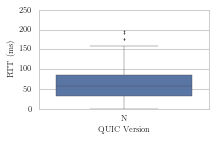

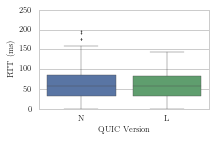

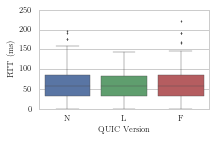

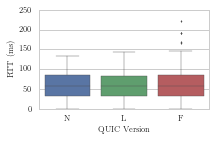

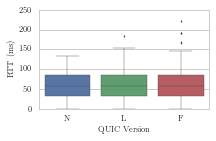

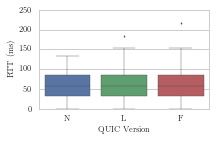

In [25]:
dfAll = pd.DataFrame()
connection='WiFi' # 'WiFi' or 'ETH'
interval='200'
for f in glob.iglob('./no-loss/*'+connection+'*-'+interval+'ms*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])
    dfclient = pd.read_csv(f+'clientStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'msg_number'])
    dfkpi = pd.read_csv(f+'firstKPIs', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'cwin', 'bytes-in-flight', 'nb-ret', 'rtt_min', 'crtt', 'sendtime', 
                                         'latest_msg', 'currentackdelay', 'srtt', 'rttvar', 'maxackdelay', 'state'])
    print(f)
    
    dfkpi['crtt'] = dfkpi.crtt.apply(lambda x: x / 1000) # from us to ms
    
    msgs_sent = dfclient.msg_number.size
    msgs_received = dfstream.msg_number.size
    
    dfclient['duplicate'] = dfclient.msg_number.duplicated()
    
    retryList = [];
    retryWithoutDuplicates = [];
    for i, value in enumerate(dfclient.duplicate):
        if(value):
            retryList.append(dfclient.msg_number[i])
            if(dfclient.msg_number[i] not in retryWithoutDuplicates):
                retryWithoutDuplicates.append(dfclient.msg_number[i])
    
    retriesPerMsg = [];
    for msgID in retryList:
        if(msgID not in retriesPerMsg):
            retriesPerMsg.append(retryList.count(msgID))
    
    retries = pd.Series(retriesPerMsg)
    
    #look if the retransmit messages have arrived
    arrivedRetransmits = [];

    for msg in retryWithoutDuplicates:
        if dfstream.msg_number[dfstream.msg_number == msg].size > 0:
            arrivedRetransmits.append(msg)
    
    
    print('Sent by Client:', 'Received by Server:\n', 
          msgs_sent, msgs_received)
    print('Retransmissions by Client:', 'Re-Retransmissions:', 'Successful Retransmissions: \n',
          len(retryList), len(retryList)-len(retryWithoutDuplicates), len(arrivedRetransmits))
    print('Retransmissions rate:', round((len(retryList)/msgs_sent)*100, 2), '%')
    if(len(retryList)>0):
        print('Successful Retransmissions rate:', round((len(arrivedRetransmits)/len(retryList))*100, 2), '%')
    else:
        print('Successful Retransmissions rate:', 'no retransmits')
    print('median:', dfkpi.crtt.median())
    print('max:', dfkpi.crtt.max(),'min:', dfkpi.crtt.min(),'mean:', dfkpi.crtt.mean(), 'var:', dfkpi.crtt.var())
    print('\n')
    
    plt.figure()
    #sns.boxplot(x='crtt', data=dfkpi)
    
    if '-N' in f:
        dfAll['N'] = dfkpi['crtt']
    if '-L' in f:
        dfAll['L'] = dfkpi['crtt']
    if '-F' in f:
        dfAll['F'] = dfkpi['crtt']
    
    print('\n')
    
    #dfkpi.plot.scatter(x='seconds_offset', y='crtt', s=0.1)

    fig = sns.boxplot(data=dfAll, fliersize=2.0)
    
    plt.ylim([0,250])
    plt.xlabel('QUIC Version')
    plt.ylabel('RTT (ms)')
    
    plt.tight_layout()
    plt.savefig(f+interval+"ms_crtt_boxplot.pdf")
        
#print(dfAll)
#dfAll.boxplot(by='Version', showfliers=False)

In [5]:
experimentsC=[]
connection='WiFi' # 'WiFi' or 'ETH'
interval='100'
for f in glob.iglob('./*'+connection+'*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                    ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    del dfapp['length']
    print(f)

# set all to same dataframe size
    #dfapp = dfapp.head(25650)
    
    dfapp.onewaydelay = dfapp.onewaydelay.apply(lambda x: x / 1000) # from us to ms

    sortedOneWayDelay = dfapp['onewaydelay'].sort_values()
    #print(sortedOneWayDelay.size)
    
    outdated = pd.Series();
    inTime = pd.Series();
    for i, value in enumerate(dfapp.onewaydelay):
        if(value>interval):
            outdated = outdated.set_value(i, value)
        else:
            inTime = inTime.set_value(i, value)
            
    if(outdated.size == 0):
        outdatedsize=0; 
        outdatedmin=0;
        outdatedmean=0;
        outdatedmax=0;
    else:
        outdatedsize= outdated.size;
        outdatedmin=outdated.min();
        outdatedmean=outdated.mean();
        outdatedmax=outdated.max();
        
#     print('Outdated:', outdatedsize, 'min:', outdatedmin, 'mean:', outdatedmean, 
#             'median:', outdated.median(), 'max:', outdatedmax, ' (all delays in ms)')
#     print('MsgsInTime:', inTime.size, 'min:', inTime.min(), 'mean:', inTime.mean(), 
#             'median:', inTime.median(), 'max:', inTime.max(), ' (all delays in ms)\n')
    
    
#     #build the CDF
#     cum_dist = np.linspace(1.,0.,len(sortedOneWayDelay))
#     cdf = pd.Series(cum_dist, index=sortedOneWayDelay)
#     fig = plt.figure() #this line makes a plot for every file
#     fig = cdf.plot(color='r', linestyle=':', drawstyle='steps')
    
#     #fig.text(sortedRetrans.max()*0.75, 0.9, num_retrans, horizontalalignment='center', verticalalignment='center')

#     fig.set_xlabel('Delay of packets (ms)')
#     fig.set_yscale('log')
#     plt.tight_layout()
#     plt.savefig(f+"ccdf_one-way-delay_app.pdf")
    
    experimentName=f[f.find('2019'):]
    #print(experimentName)
    experimentsC.append([experimentName, sortedOneWayDelay.size, inTime.size, inTime.min(), inTime.mean(), inTime.max(), outdatedsize, outdatedmin, outdatedmean, outdatedmax])

#pprint(experimentsC)

# cut out ephemeral version name from experiment name
for i in experimentsC:
    if 'N' in i[0][i[0].rfind('00ms')+4:i[0].rfind('ephemeral')+9]:
         i[0] = 'N'
    if 'L' in i[0][i[0].rfind('00ms')+4:i[0].rfind('ephemeral')+9]:
         i[0] = 'L'
    if 'F' in i[0][i[0].rfind('00ms')+4:i[0].rfind('ephemeral')+9]:
         i[0] = 'F'

dfAll = pd.DataFrame()
dfAll['Version'] = pd.Series(i[0] for i in experimentsC)
dfAll['received'] = pd.Series(i[1] for i in experimentsC)
dfAll['inTime'] = pd.Series(i[2] for i in experimentsC)
dfAll['inTime_min'] = pd.Series(i[3] for i in experimentsC)
dfAll['inTime_mean'] = pd.Series(i[4] for i in experimentsC)
dfAll['inTime_max'] = pd.Series(i[5] for i in experimentsC)
dfAll['outdated'] = pd.Series(i[6] for i in experimentsC)
dfAll['outdated_min'] = pd.Series(i[7] for i in experimentsC)
dfAll['outdated_mean'] = pd.Series(i[8] for i in experimentsC)
dfAll['outdated_max'] = pd.Series(i[9] for i in experimentsC)
dfAll.sort_values(by=['Version'], ascending=False, inplace=True)

print(dfAll)
print()



#plt.tight_layout()
#plt.savefig(f+connection+"_inTime+outdated.pdf")

.\20191211-224341_WiFi-6000msgs-100-500ms-N-ephemeral\
.\20191211-233443_WiFi-6000msgs-100-500ms-L-ephemeral\
.\20191212-002544_WiFi-6000msgs-100-500ms-F-ephemeral\
.\20191212-011645_WiFi-6000msgs-100-500ms-N-ephemeral\
.\20191212-020746_WiFi-6000msgs-100-500ms-L-ephemeral\
.\20191212-025847_WiFi-6000msgs-100-500ms-F-ephemeral\
.\20191212-034948_WiFi-6000msgs-100-500ms-N-ephemeral\
.\20191212-044049_WiFi-6000msgs-100-500ms-L-ephemeral\
.\20191212-053150_WiFi-6000msgs-100-500ms-F-ephemeral\
.\20191212-062251_WiFi-6000msgs-100-500ms-N-ephemeral\
.\20191212-071352_WiFi-6000msgs-100-500ms-L-ephemeral\
.\20191212-080454_WiFi-6000msgs-100-500ms-F-ephemeral\
   Version  received  inTime  inTime_min  inTime_mean  inTime_max  outdated  \
0        N      6000    6000       0.957    62.754496     418.831         0   
3        N      6000    6000       2.057    62.603790     264.690         0   
6        N      6000    6000       2.044    62.092300     384.529         0   
9        N      6000    

In [6]:
# HOLES: APP LEVEL
# msgs consecutively lost (holes)
experiments = []
connection='WiFi' #WiFi or ETH
interval = 500
for f in glob.iglob('./*'+connection+'*500*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])

    title=f
    print(f)
    del dfstream['length']
    dfstream.onewaydelay = dfstream.onewaydelay.apply(lambda x: x / 1000) # from us to ms
    dfapp.onewaydelay = dfapp.onewaydelay.apply(lambda x: int(x) / 1000) # from us to ms

# set all to same dataframe size
    #dfapp = dfapp.head(25650)    
    
    
    holes = []
    h=1;
    case=''
    for i, seconds in enumerate(dfapp.seconds_offset):
        if (i+1 < dfapp.seconds_offset.size): #out of bounds check
            t1 = seconds;
            t2 = dfapp.seconds_offset[i+1]
            n1 = dfapp.msg_number[i]
            n2 = dfapp.msg_number[i+1]
            if(t2 - t1 > 0.2): # hole detected by offset (but maybe msg before was also outdated!)
                
                if(dfapp.onewaydelay[i] < interval): # was msg[i] already outdated?
                    # msg[i] not outdated
                    
                    if(dfapp.onewaydelay[i+1] > interval): #is msg[i+1] actually the end of the hole?
                        k=2 #look forward until next "msg-in-time" was found
                        while (i+k < len(dfapp.index) and dfapp.onewaydelay[i+k] > 100):
                            k+=1
                        if(i+k < len(dfapp.index)):
                            n2 = dfapp.msg_number[i+k]
                            t2 = dfapp.seconds_offset[i+k]
                            case = 'i to i+k'
                    else:
                        case = 'i to i+1'
                        
                else:
                    # msg[i] is outdated
                    
                    j=1 # look back until last "msg-in-time" was found
                    while (dfapp.onewaydelay[i-j] > interval):
                        j+=1
                    n1 = dfapp.msg_number[i-j] #update real beginning of hole
                    t1 = dfapp.seconds_offset[i-j]
                    
                    if(dfapp.onewaydelay[i+1] > interval): #is it actually the end of the hole?
                        k=2 #look forward until next "msg-in-time" was found
                        while (i+k < len(dfapp.index) and dfapp.onewaydelay[i+k] > 100):
                            k+=1
                        if(i+k < len(dfapp.index)):
                            n2 = dfapp.msg_number[i+k]
                            t2 = dfapp.seconds_offset[i+k]
                            case = 'i-j to i+k'
                        else:
                            print('OUT OF BOUNDS')
                    else: # it is already the end
                        case = 'i-j to i+1'
                        
                holes.append([n1, n2, n2-n1, (t2-t1) * 1000, case]) # msg 1, msg 2, msg difference, time difference
                #print(h, case, [n1, n2, n2-n1, str(round((t2-t1) * 1000, 2))])
                #h+=1
    
    holeTimes = pd.Series(i[3] for i in holes)
    holeMsgs = pd.Series(i[2] for i in holes)
    
    print('Hole sizes (ms): occurrences=', holeTimes.size, 'min=', holeTimes.min(), 'mean=', round(holeTimes.mean(), 2), 'median=', round(holeTimes.median(), 2), 'max=', holeTimes.max())
    print('Hole sizes (msgs): occurrences=', holeMsgs.size, 'min=', holeMsgs.min(), 'mean=', round(holeMsgs.mean(), 2), 'median=', round(holeMsgs.median(), 2), 'max=', holeMsgs.max(), '\n')
   
    #set parameters and check if occurences = 0 -> mean, median, max also 0 then
    
    experimentName=f[f.find('2019'):]
    #print(experimentName)
    experiments.append([experimentName, holeTimes.size, round(holeTimes.mean(), 2), round(holeTimes.median(), 2), holeTimes.max()])
    #experiments.append([experimentName, holeTimes.mean()])

# build dataframes from values computed above
#pprint(experiments)

dfAll = pd.DataFrame()
dfAll['Version'] = pd.Series(i[0][i[0].rfind('00ms')+5:i[0].rfind('-ephemeral')] for i in experiments)
dfAll['occurrences'] = pd.Series(i[1] for i in experiments)
dfAll['meandelay'] = pd.Series(i[2] for i in experiments)
dfAll['median'] = pd.Series(i[3] for i in experiments)
dfAll['maxdelay'] = pd.Series(i[4] for i in experiments)

print(dfAll.sort_values('Version')) 

#dfAll.groupby('Version').max()
dfAll.groupby('Version').mean()
#dfAll.groupby('Version').min()


# plt.tight_layout()
# plt.savefig(f+connection+"_XXX.pdf")


.\20191211-224341_WiFi-6000msgs-100-500ms-N-ephemeral\
Hole sizes (ms): occurrences= 5997 min= 301.382 mean= 500.11 median= 511.91 max= 829.99
Hole sizes (msgs): occurrences= 5997 min= 1 mean= 1.0 median= 1.0 max= 1 

.\20191211-233443_WiFi-6000msgs-100-500ms-L-ephemeral\
Hole sizes (ms): occurrences= 5999 min= 295.442 mean= 499.99 median= 511.94 max= 638.349
Hole sizes (msgs): occurrences= 5999 min= 1 mean= 1.0 median= 1.0 max= 1 

.\20191212-002544_WiFi-6000msgs-100-500ms-F-ephemeral\
Hole sizes (ms): occurrences= 5999 min= 307.094 mean= 499.99 median= 511.96 max= 716.96
Hole sizes (msgs): occurrences= 5999 min= 1 mean= 1.0 median= 1.0 max= 1 

.\20191212-011645_WiFi-6000msgs-100-500ms-N-ephemeral\
Hole sizes (ms): occurrences= 5999 min= 305.132999999 mean= 499.99 median= 511.95 max= 718.241
Hole sizes (msgs): occurrences= 5999 min= 1 mean= 1.0 median= 1.0 max= 1 

.\20191212-020746_WiFi-6000msgs-100-500ms-L-ephemeral\
Hole sizes (ms): occurrences= 5999 min= 288.923 mean= 499.99 medi

,occurrences,meandelay,median,maxdelay
Version,,,,
F,5999.0,499.99,511.9575,666.61600
L,5999.0,499.99,511.9500,652.44625
N,5998.5,500.03,511.9450,746.23500
